In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.linalg import orth

#data = pd.read_csv('highly_variable_genes.csv')
data = pd.read_csv('pizza.csv')
data=data
#print(list(data))

targets=list(data['brand'])
data=data.drop(['brand','id'], axis=1)

#data=data.values

num_components = 2

In [2]:
# Principal component analysis function 

def pca(data, num_comp): #data, number of components
    data_norm = (data - np.mean(np.asarray(data), axis=0))#/ np.std(data, axis=0) #normalize the data

    cov_mat = np.cov(data_norm.T) #covariance matrix

    eig_vals, eig_vecs = np.linalg.eigh(cov_mat) #eigenvalues and eigenvectors of covariance matrix

    # Sort eigenvectors in descending order of eigenvalues
    indices = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, indices]
    eig_vals = eig_vals[indices]
    # Select the top eigenvectors and eigenvalues
    eig_vecs_selected = eig_vecs[:, :num_comp]
    eig_vals_selected = eig_vals[ :num_comp]

    # Project the data onto the new subspace defined by the selected eigenvectors
    pca_data = np.dot(data_norm, eig_vecs_selected)

    return  pca_data, eig_vecs_selected, eig_vals_selected

In [3]:
pca_data, pca_eig_vecs, pca_eig_vals = pca(data, num_components)

print(len(pca_data))
#print(eig_vec)
#print(eig_val)

300


In [38]:
# probabilistic principal component analysis function

def ppca(t, num_comp,W_init,sigma_init, max_iter=1000, tol=1e-5):

    n_samples, n_features = t.shape
    
    t_norm = np.asarray(t - np.mean(np.asarray(t), axis=0)) #normalize the data
    S=np.cov(t_norm.T)

    W=W_init
    s_squared=sigma_init
    
    sigma=sigma_init
    E_Y = t_norm
    for i in range(max_iter):

        M = (W.T @ W) + s_squared * np.eye(num_comp)
        
        MWSW = np.linalg.inv(M) @ W.T @ S @ W 
        W_new = S @ W @ np.linalg.inv(s_squared * np.eye(num_comp)+MWSW)
        
        SWMW = S @ W @ np.linalg.inv(M) @ W_new.T
        s_squared_new = np.trace(S - SWMW)/n_features
        
        # Check for convergence
        #print(s_squared_new-s_squared)
        if (np.abs(s_squared_new-s_squared) < tol):
            break

        W=W_new
        s_squared=s_squared_new

    pca_data, pca_eig_vecs, pca_eig_vals = pca(t, num_comp)
    signs=np.sign(pca_eig_vecs)

    #E_xt = np.linalg.inv(M) @ W.T @ t_norm.T
    E_xt = t_norm @ W @ np.linalg.inv(M)
    
    #recon_data_ppca = (W @ np.linalg.inv(W.T @ W) @ M @ E_xt)
    recon_data_ppca = E_xt @ W.T 
    #print(recon_data_ppca.shape)
    #recon_data_ppca = [recon_data_ppca[:,n]+np.mean(np.asarray(t), axis=0) for n in range(len(recon_data_ppca))]
    recon_data_ppca = [recon_data_ppca[n]+np.mean(np.asarray(t), axis=0) for n in range(len(recon_data_ppca))]
    print((E_xt.shape, W.shape))
    #E_xt=E_xt @ np.linalg.inv(W.T)


    basis = orth(W) # Orthonormal basis of the principal subspace
    data_p = t_norm @ basis # Projected observation matrix on the principal subspace
    S_p = np.cov(data_p.T) # Projected covariance matrix
    eig_vals, eig_vecs = np.linalg.eigh(S_p) 
    idx = list(reversed(np.argsort(eig_vals))) # Sort in decreasing order
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    W = basis @ eig_vecs # Corrected principal components

    W = np.abs(W) * signs

    ppca_data = t_norm @ W
    return ppca_data, W, s_squared, eig_vals, eig_vecs, E_xt, recon_data_ppca
        

In [40]:

W_init = np.random.randn(data.shape[1], num_components)
#print(W_init)
s_init=1
ppca_data, W, s_squared, ppca_eig_vals, ppca_eig_vecs,E_xt, recon_data_ppca = ppca(data, num_components,W_init,s_init)

reconstructed_data_pca = np.dot(pca_data, pca_eig_vecs.T) + np.mean(np.asarray(data), axis=0)
reconstructed_data_ppca = np.dot(ppca_data, W.T) + np.mean(np.asarray(data), axis=0)

#print(pca_eig_vecs)
#print(W)
print(E_xt[0:5,:], E_xt.shape)
print(pca_data[0:5,:], pca_data.shape)
print(ppca_data[0:5,:], ppca_data.shape)

#print(reconstructed_data_pca[0])
#print(reconstructed_data_ppca[0])
#print(recon_data_ppca[0])
#print(np.asarray(data)[0])

((300, 2), (7, 2))
[[-0.09035004 -2.90279176]
 [-0.1204367  -2.79327112]
 [-0.08500038 -2.91308964]
 [-0.19214966 -2.5973557 ]
 [-0.20548715 -2.51036995]] (300, 2)
[[-24.95174791 -26.81166776]
 [-24.61197575 -25.6595634 ]
 [-24.93841905 -26.93057098]
 [-24.32556095 -23.52356712]
 [-23.8660483  -22.65281282]] (300, 2)
[[-24.95174791 -26.81166776]
 [-24.61197575 -25.6595634 ]
 [-24.93841905 -26.93057098]
 [-24.32556095 -23.52356712]
 [-23.8660483  -22.65281282]] (300, 2)


In [54]:
from sklearn.decomposition import PCA

# Instantiate PCA with desired number of components
pca = PCA(n_components=num_components)

# Fit and transform the data to the new coordinate system
X_pca = pca.fit(data)
signs=np.sign(X_pca.components_.T)
print(X_pca.components_.T)
print(np.abs(pca_eig_vecs)*signs)
print(np.abs(W)*signs)

[[-2.76963426e-01 -7.47073681e-01]
 [-2.66941457e-01  5.57329479e-02]
 [-2.78933559e-01  6.57845306e-01]
 [-5.54340960e-02  4.06042105e-02]
 [-1.11416057e-02  2.38137604e-02]
 [ 8.78084364e-01 -6.81755096e-03]
 [-6.03287596e-04  6.12538275e-02]]
[[-2.76963426e-01 -7.47073681e-01]
 [-2.66941457e-01  5.57329479e-02]
 [-2.78933559e-01  6.57845306e-01]
 [-5.54340960e-02  4.06042105e-02]
 [-1.11416057e-02  2.38137604e-02]
 [ 8.78084364e-01 -6.81755096e-03]
 [-6.03287596e-04  6.12538275e-02]]
[[-2.76963426e-01 -7.47073681e-01]
 [-2.66941457e-01  5.57329479e-02]
 [-2.78933559e-01  6.57845306e-01]
 [-5.54340960e-02  4.06042105e-02]
 [-1.11416057e-02  2.38137604e-02]
 [ 8.78084364e-01 -6.81755096e-03]
 [-6.03287596e-04  6.12538275e-02]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\hanno\AppData\Local\Temp\ipykernel_19228\407699231.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


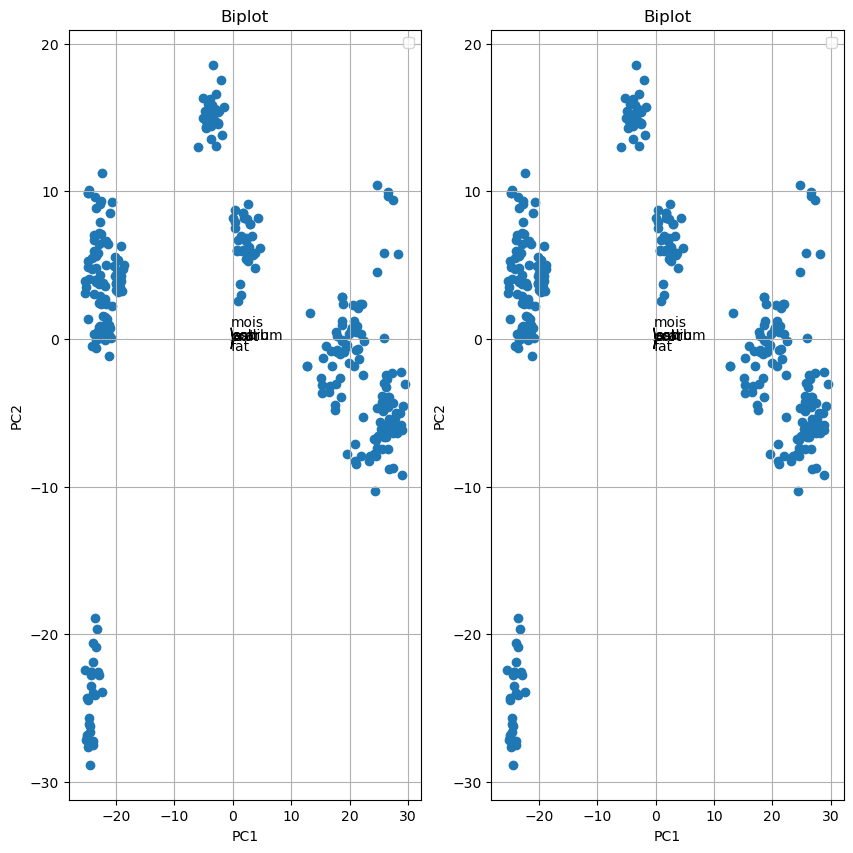

In [55]:
def biplot(data,pca_data,pca_eig_vecs,ax,targets=[]):
    X_r = pca_data

    # Create DataFrame for easier handling
    df = pd.DataFrame(X_r, columns=['PC1', 'PC2'])
    if len(targets)>0:
        df['target'] = targets

        for i,target in enumerate(np.unique(targets)):
            subset = df[df['target'] == target]
            ax.scatter(subset['PC1'], subset['PC2'], label=target)
    else:
        ax.scatter(df['PC1'],df['PC2'])

    # Add variable loadings
    scaling=1
    for i, var_name in enumerate(data.columns):
        ax.arrow(0, 0, pca_eig_vecs[i,0]*scaling, pca_eig_vecs[i,1]*scaling,
                head_width=0.01, head_length=0.01, color='k')
        ax.text(pca_eig_vecs[i,0] * 1.15*scaling, pca_eig_vecs[i,1] * 1.15*scaling,
                var_name, color='k')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Biplot')
    ax.legend(ncol=5)
    ax.grid(True)

fig,ax=plt.subplots(1,2,figsize=(10,10))
biplot(data,pca_data,pca_eig_vecs,ax[0])
biplot(data,ppca_data,W,ax[1])
fig.show()

C:\Users\hanno\AppData\Local\Temp\ipykernel_19228\3314267019.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


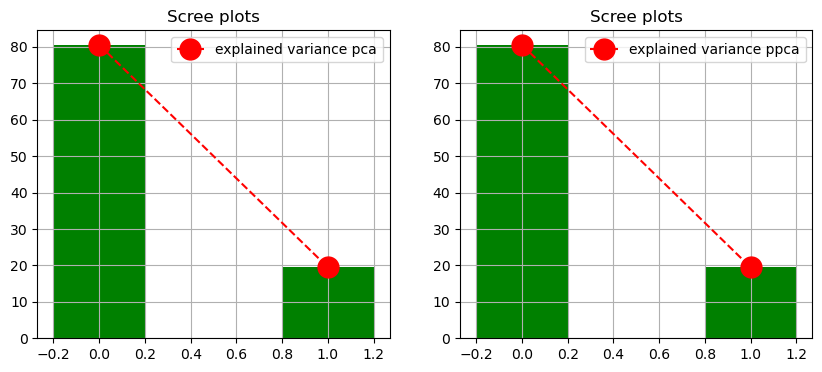

In [56]:

#YC = np.dot(principal_components)
#print("This is the dimension of the Y matrix \t {}\n\t(*) using the loadings of the covariance matrix C\n"
#      "\t(*) It must be equal to the dimension of the original dataset\n".format(np.shape(YC)))
def explained_variance_plot(eig_vals, ax, label):
      total_var = np.sum(eig_vals)
      explained_var = np.asarray(
      [100*(i/total_var) for i in sorted(eig_vals, reverse=True)])
      ax.set_title("Scree plots")
      ax.bar(x=np.arange(np.shape(explained_var)[0]), 
            height=explained_var, 
            width=0.4, color="green")
      ax.plot(np.arange(np.shape(explained_var)[0]), 
            explained_var, 
            linestyle="--", marker="o", markersize=15,
            color="red", label="explained variance "+label)
      ax.legend()
      ax.grid()
      return explained_var

#fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0])
explained_variance_plot(pca_eig_vals, ax1, 'pca')
ax2 = plt.subplot(gs[1])
explained_variance_plot(ppca_eig_vals, ax2, 'ppca')
fig.show()

[[-2.76963426e-01  7.47073681e-01]
 [-2.66941457e-01 -5.57329479e-02]
 [-2.78933559e-01 -6.57845306e-01]
 [-5.54340960e-02 -4.06042105e-02]
 [-1.11416057e-02 -2.38137604e-02]
 [ 8.78084364e-01  6.81755096e-03]
 [-6.03287596e-04 -6.12538275e-02]]
[-24.95174791 -26.81166776]


C:\Users\hanno\AppData\Local\Temp\ipykernel_19228\1703742581.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


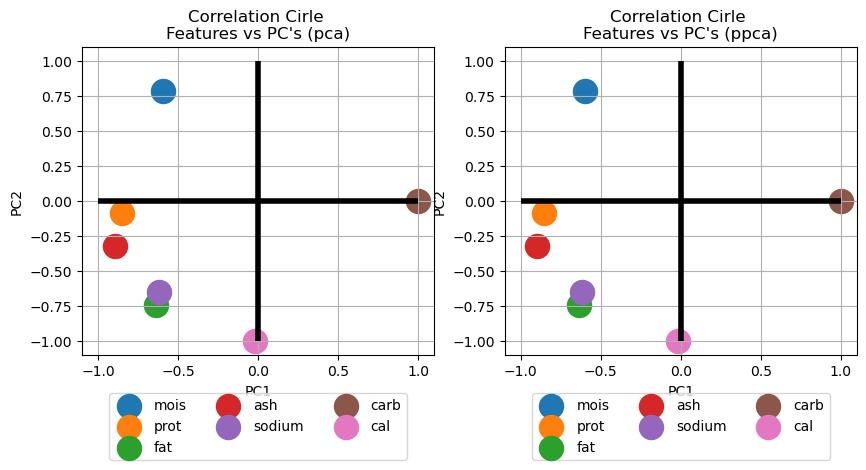

In [57]:
def corr_circle_plot(data,pca_data, ax, label):
    data_norm = np.asarray(data - np.mean(data, axis=0))
    CC = []
    for i in range(np.shape(data_norm)[1]):
        f = []
        for j in range(np.shape(pca_data)[1]):
            c = (np.corrcoef(data_norm[:,i], pca_data[:,j])[0])[1]
            f.append(c)
        CC.append(f)
    CC = np.asarray(CC)
    #print(CC)

    ax.set_title("Correlation Cirle \nFeatures vs PC's ("+label+")")
    ax.hlines(y=0, xmin=-1, xmax=1, colors='black', linewidth=4, linestyle='solid')
    ax.vlines(x=0, ymin=-1, ymax=1, colors='black', linewidth=4, linestyle='solid')
    for i in range(0,np.shape(data_norm)[1]):
        ax.scatter(CC[i:i+1,0:1], 
                    CC[i:i+1,1:2], s=300, label=data.columns[i])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
            fancybox=True, ncol=3)
    ax.grid()

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0])
print(pca_eig_vecs)
print(ppca_data[0])
corr_circle_plot(data,pca_data, ax1, 'pca')
ax2 = plt.subplot(gs[1])
corr_circle_plot(data,ppca_data, ax2, 'ppca')
fig.show()

In [58]:
def MSE(original_data,recon_data):
    # Calculate the squared differences between corresponding data points
    squared_diff = [(np.array(og) - np.array(rec)) ** 2 
                    for og, rec in zip(original_data, recon_data)]
    # Calculate the mean of the squared differences
    mse = np.mean(squared_diff)

    return mse

x=[]
y1=[]
y2=[]
for i in range(2,10):
    x.append(i)

    pca_data, pca_eig_vecs, pca_eig_vals = pca(data, i)
    reconstructed_data_pca = np.dot(pca_data, pca_eig_vecs.T) + np.mean(np.asarray(data), axis=0)
    y1.append(MSE(np.asarray(data),reconstructed_data_pca))

    W_init = np.random.randn(data.shape[1], i)
    s_init=1
    ppca_data, W, s_squared, ppca_eig_vals, ppca_eig_vecs = ppca(data, i,W_init,s_init)
    reconstructed_data_ppca = np.dot(ppca_data, W.T) + np.mean(np.asarray(data), axis=0)
    y2.append(MSE(np.asarray(data),reconstructed_data_ppca))

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])
sns.lineplot(x=x, y=y1, label='pca', palette=sns.color_palette("husl"),ax=ax)
sns.lineplot(x=x, y=y2, label='ppca', palette=sns.color_palette("husl"),ax=ax)
ax.set_xlabel('# principal components')
ax.set_ylabel('MSE')
ax.legend()
fig.show()

print(MSE(np.asarray(data),reconstructed_data_pca))
print(MSE(np.asarray(data),reconstructed_data_ppca))

TypeError: 'PCA' object is not callable

C:\Users\hanno\AppData\Local\Temp\ipykernel_8472\3648287917.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x1, y=y1, label='ppca', palette=sns.color_palette("husl"),ax=ax1)
C:\Users\hanno\AppData\Local\Temp\ipykernel_8472\3648287917.py:43: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x2, y=y2, label='ppca', palette=sns.color_palette("husl"),ax=ax2)
C:\Users\hanno\AppData\Local\Temp\ipykernel_8472\3648287917.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x3, y=y3, label='ppca', palette=sns.color_palette("husl"),ax=ax3)
C:\Users\hanno\AppData\Local\Temp\ipykernel_8472\3648287917.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


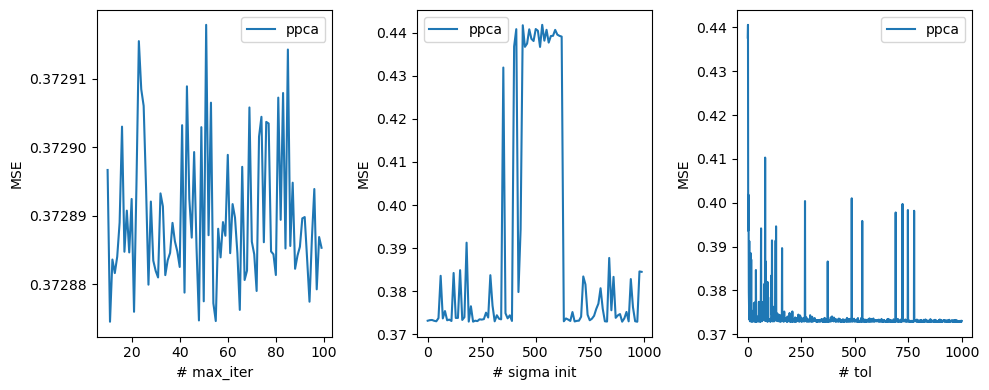

In [ ]:
x1=[]
y1=[]
for max_iter in range(10,100,1):
    x1.append(max_iter)

    W_init = np.random.randn(data.shape[1], num_components)
    s_init=1
    ppca_data, W, s_squared, ppca_eig_vals, ppca_eig_vecs = ppca(data, num_components,W_init,s_init,max_iter=max_iter, tol=1e-4)
    reconstructed_data_ppca = np.dot(ppca_data, W.T) + np.mean(np.asarray(data), axis=0)
    y1.append(MSE(np.asarray(data),reconstructed_data_ppca))

x2=[]
y2=[]
for s_init in range(0,1000,10):
    x2.append(s_init)

    W_init = np.random.randn(data.shape[1], num_components)
    s_init=s_init/1000
    ppca_data, W, s_squared, ppca_eig_vals, ppca_eig_vecs = ppca(data, num_components,W_init,s_init,max_iter=100, tol=1e-1)
    reconstructed_data_ppca = np.dot(ppca_data, W.T) + np.mean(np.asarray(data), axis=0)
    y2.append(MSE(np.asarray(data),reconstructed_data_ppca))

x3=[]
y3=[]
for tol in range(1,1000,1):
    x3.append(tol)

    W_init = np.random.randn(data.shape[1], num_components)
    s_init=1
    ppca_data, W, s_squared, ppca_eig_vals, ppca_eig_vecs = ppca(data, num_components,W_init,s_init,max_iter=100, tol=1/(tol))
    reconstructed_data_ppca = np.dot(ppca_data, W.T) + np.mean(np.asarray(data), axis=0)
    y3.append(MSE(np.asarray(data),reconstructed_data_ppca))

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0])
ax2=plt.subplot(gs[1])
ax3=plt.subplot(gs[2])
sns.lineplot(x=x1, y=y1, label='ppca', palette=sns.color_palette("husl"),ax=ax1)
ax1.set_xlabel('# max_iter')
ax1.set_ylabel('MSE')
ax1.legend()
sns.lineplot(x=x2, y=y2, label='ppca', palette=sns.color_palette("husl"),ax=ax2)
ax2.set_xlabel('# sigma init')
ax2.set_ylabel('MSE')
ax2.legend()
sns.lineplot(x=x3, y=y3, label='ppca', palette=sns.color_palette("husl"),ax=ax3)
ax3.set_xlabel('# tol')
ax3.set_ylabel('MSE')
ax3.legend()
fig.tight_layout()
fig.show()